In [2]:
import pandas as pd
import numpy as np
import h5py
import os
import datetime
import copy
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['axes.facecolor'] = 'w'

In [3]:
year, month, day = '2021', '10', '15'
start_date = pd.Timestamp(year + '.' + month.zfill(2) + '.' + day.zfill(2))
tmax = '30'
daysPlot = 30

#define scenarios
strings = ['']
#strings = ['_future_high_mask_test']
#define compartments
secir_dict = {0:'Susceptible', 1:'Partially Vaccinated', 2:'Exposed', 3:'ExposedV1', 4:'ExposedV2', 5:'Carrier',
              6:'CarrierV1',7:'CarrierV2', 8:'CarrierT', 9:'CarrierTV1', 10:'CarrierTV2', 11:'Infected',
              12:'InfectedV1',13:'InfectedV2', 14:'InfectedT', 15:'InfectedTV1', 16:'InfectedTV2',
              17:'Hospitalized', 18:'HospitalizedV1', 19:'HospitalizedV2', 20:'ICU',
              21:'ICUV1', 22:'ICUV2', 23:'Immune', 24:'Dead', 25: 'Infected Total'}
new_secir_dict = {0:'Susceptible', 1:'Partially Vaccinated', 2:'Exposed', 3:'Carrier', 4:'Detected',
              5:'Hospitalized', 6:'ICU', 7:'Immune', 8:'Dead', 9: 'Infected Total'}
concat_comps = {0:[0], 1:[1], 2:[2,3,4], 3:[5,6,7,8,9,10], 4:[11, 12, 13, 14, 15, 16],
            5:[17, 18, 19], 6:[20, 21, 22], 7:[23], 8:[24], 9:[25]}

#define age groups
age_groups = ['0-4 Years', '5-14 Years', '15-34 Years', '35-59 Years', '60-79 Years', '80+ Years']

### Plot parameters

In [4]:
# define colors for age groups
plt_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
print(get_cmap(0))
colors = {}
colors['Total'] = plt_colors[0]
for i in range(len(age_groups)):
    colors['Group' + str(i+1)] = plt_colors[i]
    


In [5]:
# define population data for incidence values
base = 100000
age_group_sizes = np.array([3961376,7429883,19117865,28919134,18057318,5681135])

relative_dict = {}
for i in range(len(age_group_sizes)):
    relative_dict['Group' + str(i+1)] = age_group_sizes[i]/base
    
relative_dict['Total'] = np.sum(age_group_sizes)/base

    

In [6]:
plotRKI = False           # Plots RKI Data if true
plotRelative = False     # Plots incidence values if true
plotPercentiles = True  # Plots 25 and 75 percentiles if true
plotConfidence = False   # Plots 05 and 95 percentiles if true

In [7]:
savePlot = True          # saves plot file if true
if savePlot:
    try:
        os.mkdir('Plots')
    except:
        print('Directory "Plots" already exists')

Directory "Plots" already exists


In [31]:


opacity = 0.15           
lineWidth = 3.5
fontsize = 16
figsize = (8, 6)

In [9]:
scenario_label = {
    '': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_long': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_long_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_long_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_long_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_future_long': 'No commuter testing, no local NPIs' ,
    '_future_long_mask_test': 'No commuter testing, no local NPIs except for masks and distancing',  
    '_future': 'No commuter testing, no local NPIs' ,
    '_future_mask_test': 'No commuter testing, no local NPIs except for masks and distancing', 
    '_high': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_high_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_high_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_high_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_long_high': 'No commuter testing, local NPIs decreed until July 1st, no masks after opening' ,
    '_long_high_late': 'No commuter testing, local NPIs decreed until August 1st, no masks after opening' ,
    '_long_high_mask_test': 'Commuter testing, local NPIs decreed until July 1st, keeping masks and distancing', 
    '_long_high_late_mask_test': 'Commuter testing, local NPIs decreed until August 1st, keeping masks and distancing',
    '_future_long_high': 'No commuter testing, no local NPIs' ,
    '_future_long_high_mask_test': 'No commuter testing, no local NPIs except for masks and distancing',  
    '_future_high': 'No commuter testing, no local NPIs' ,
    '_future_high_mask_test': 'No commuter testing, no local NPIs except for masks and distancing',
    '7_future_high_mask_test': 'S1: contact reduc. x%',
    '6_future_high_mask_test': 'S2: contact reduc. y%',
    '5_future_high_mask_test': 'S3: contact reduc. z%'
}

In [83]:
def plot_results(files, comp_idx, title, ylim=None, filename='', key='Total', plotLegend=True):
    fig, ax = plt.subplots(figsize=figsize)
        
    
    if plotRelative:
        factor = relative_dict[key]
    else:
        factor = 1

    X = np.arange(daysPlot)
        
    if plotRKI:
        ax.plot(X[:daysPlotRKI], d[key][:daysPlotRKI, comp_idx]/factor,'x--', label='RKI',
            color='gray', linewidth=lineWidth)
        
    ax.plot(X, files['p50']['0'][key][:daysPlot, comp_idx]/factor, label='p50',
            color=colors[key], linewidth=lineWidth)
    if plotPercentiles:    
        ax.plot(X, files['p25']['0'][key][:daysPlot, comp_idx]/factor,'--', label='p25',
                color=colors[key], linewidth=lineWidth)
        ax.plot(X, files['p75']['0'][key][:daysPlot, comp_idx]/factor,'--',  label='p75',
                color=colors[key], linewidth=lineWidth)
        ax.fill_between(X, files['p25']['0'][key][:daysPlot, comp_idx]/factor,
                        files['p75']['0'][key][:daysPlot, comp_idx]/factor,
                        color=colors[key], alpha=opacity) 
    if plotConfidence:    
        ax.plot(X, files['p05']['0'][key][:daysPlot, comp_idx]/factor,'--', label='p05',
                color=colors[key], linewidth=lineWidth)
        ax.plot(X, files['p95']['0'][key][:daysPlot, comp_idx]/factor,'--',  label='p95',
                color=colors[key], linewidth=lineWidth)
        ax.fill_between(X, files['p05']['0'][key][:daysPlot, comp_idx]/factor, 
                        files['p95']['0'][key][:daysPlot, comp_idx]/factor,
                        color=colors[key], alpha=opacity) 
        
    if plotRKI:
        ax.plot(X[:daysPlotRKI], d[key][:daysPlotRKI, comp_idx]/factor,'x--',
            color='gray', linewidth=lineWidth)
        

    # ax.set_title(title, fontsize=fontsize)
    ax.set_xticks(tick_range)
    ax.set_xticklabels(datelist[tick_range], fontsize=fontsize)
    fig.autofmt_xdate(rotation=45)
    if plotRelative:
        ax.set_ylabel('individuals relative per 100.000', fontsize=fontsize)
    else:
        ax.set_ylabel('Anzahl Neuinfektionen', fontsize=fontsize)
    if plotLegend:
        ax.legend(fontsize=fontsize, loc='upper left')
    plt.yticks(fontsize=fontsize)
    ax.grid(linestyle='dotted')

    if str(ylim) != 'None':
        if '_high' in filename:
            print(filename.replace('_high', ''))
            print(ax.get_ylim()[1])
            ylim[filename.replace('_high', '')] = ax.get_ylim()[1]
        else:
            ax.set_ylim(top=ylim[filename])

    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
    ax.yaxis.offsetText.set_fontsize(fontsize)

    fig.tight_layout()
    
    if savePlot:
        if plotRKI:
            fig.savefig('Plots/RKI_' + title.replace(' ', '_') + filename + '.png')
        else:
            fig.savefig('Plots/' + title.replace(' ', '_') + filename + '.png')

    return ylim


In [11]:
def plot_all_results(all_files, comp_idx, title, filename = '', key='Total', show_perc=False):
    fig, ax = plt.subplots(figsize=figsize)
        
    fs = 16
    
    for scenario, color in zip(all_files, list(colors.values())[1:]):
        files = all_files[scenario]
        if plotRelative:
            factor = relative_dict[key]
        else:
            factor = 1
            
        X = np.arange(daysPlot)
        
        ax.plot(X, files['p50']['14'][key][:daysPlot, comp_idx]/factor, label= scenario_label[scenario],
                color=color,linewidth=lineWidth)

        if show_perc:    
            ax.plot(X, files['p25']['14'][key][:daysPlot, comp_idx]/factor,'--',
                    color=color, linewidth=lineWidth)
            ax.plot(X, files['p75']['14'][key][:daysPlot, comp_idx]/factor,'--',
                    color=color, linewidth=lineWidth)
            ax.fill_between(X, files['p25']['14'][key][:daysPlot, comp_idx]/factor,
                            files['p75']['14'][key][:daysPlot, comp_idx]/factor,
                            color=color, alpha=opacity) 
            
    if plotRKI:
        ax.plot(X[:daysPlotRKI], rki_df[key][:daysPlotRKI, comp_idx]/factor,'--', label='RKI',
            color='gray', linewidth=lineWidth)
        

    ax.set_title(title, fontsize=fs)
    ax.set_xticks(tick_range)
    ax.set_xticklabels(datelist[tick_range], rotation=45, fontsize=fs)
    
    if plotRelative:
        ax.set_ylabel('individuals relative per 100.000', fontsize=fs)
    else:
        ax.set_ylabel('number of individuals', fontsize=fs)
    ax.legend(fontsize=10)
    plt.yticks(fontsize=fs)
    ax.grid(linestyle='dotted')
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
    ax.yaxis.set_major_formatter(formatter) 
    ax.yaxis.offsetText.set_fontsize(fs)
    
    fig.tight_layout()
    
    if savePlot:
        fig.savefig('Plots/' + title.replace(' ', '_') + filename + '.png')


In [12]:
#reduce rki json file
import pandas.io.json
df = pd.read_json('../cpp/input/data/pydata/Germany/all_county_age_ma7_rki.json')
df = df[df.Date.dt.date >= datetime.date(2021, 9, 1)]

df.Date = df.Date.dt.strftime('%Y-%m-%d')
pandas.io.json.to_json('../cpp/input/data/pydata/Germany/all_county_age_ma7_rki.json.new', df, orient = 'records')

In [13]:
def open_files(iter = ''):
    # load files
    files = {}

    for scenario in strings:
        files[scenario] = {}

        path = '../cpp/output_' + scenario

        files[scenario]['p50'] = h5py.File(path + '/p50/Results_sum.h5', 'r+')
        
        files[scenario]['p25'] = h5py.File(path + '/p25/Results_sum.h5', 'r+')
        files[scenario]['p75'] = h5py.File(path + '/p75/Results_sum.h5', 'r+')

        files[scenario]['p05'] = h5py.File(path + '/p05/Results_sum.h5', 'r+')
        files[scenario]['p95'] = h5py.File(path + '/p95/Results_sum.h5', 'r+')

        if plotRKI:
            pass
            # files[scenario]['RKI'] = h5py.File('../cpp/output/Results_rki.h5', 'r+')
            # if month == '6':
            #     files[scenario]['RKI'] = h5py.File('../cpp/output/Results_rki.h5', 'r+')
            # elif month == '10':
            #     files[scenario]['RKI'] = h5py.File('../cpp/output/Results_rki_future.h5', 'r+')

    
    return files

def close_files(files):
    for group in files:
        for file in files[group]:
            files[group][file].close()



In [14]:
def concat_comparts(files, comparts):
    new_files = {}
    for scenario in strings:
        print(scenario)
        new_files[scenario] = {}
        percentile_list = ['p50', 'p25','p75','p05','p95']
        # if plotRKI:
        #     percentile_list += ['RKI']
        for p in percentile_list:
            new_files[scenario][p] = {'0':{}}
            for key in ['Group' + str(group+1) for group in range(6)] + ['Total']:
                if p == 'RKI':
                    new_files[scenario][p]['14'][key] = np.zeros((len(files[scenario][p]['14521']['Time']), len(comparts)))
                    for i in range(1000):
                        county_id = 14000 + i
                        if str(county_id) not in files[scenario][p]:
                            continue
                        for new_comp in range(len(comparts)):
                            for old_comp in comparts[new_comp]:
                                new_files[scenario][p]['14'][key][:, new_comp] += files[scenario][p][str(county_id)][key][:, old_comp]
                else:
                    new_files[scenario][p]['0'][key] = np.zeros((len(files[scenario][p]['0']['Time']), len(comparts)))
                    for new_comp in range(len(comparts)):
                        for old_comp in comparts[new_comp]:
                            new_files[scenario][p]['0'][key][:, new_comp] += files[scenario][p]['0'][key][:, old_comp]


                        
    return new_files

In [69]:
# rki_df_backup = pd.read_json('../cpp/input/data/pydata/Germany/all_county_age_ma7_rki.json')
rki_df_backup = pd.read_json('C:/Users/abel_da/Documents/miotree/memilio/data/pydata/Germany/all_county_age_ma7_rki.json')

array([ 0.,  0.,  0., ..., 89., 89., 89.])

In [80]:
year, month, day = '2021', '10', '11'
start_date = pd.Timestamp(year + '.' + month.zfill(2) + '.' + day.zfill(2))
tmax = '73'
daysPlot = 73
daysPlotRKI = 53

import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
datelist = np.array(pd.date_range(start_date.date(), periods=daysPlot, freq='D').strftime('%d. %b').tolist())
tick_range = np.arange(0, daysPlot, 7)
tick_range[-1] -= 1
plotRKI=True
plotConfidence=True

C:\Users\abel_da\AppData\Local\Temp/ipykernel_6628/681243221.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  d[key][t, 4] = rki_df_t[(rki_df.Age_RKI == key_map[key])].ConfirmedNew.sum()


Age_RKI
A00-A04    AxesSubplot(0.125,0.125;0.775x0.755)
A05-A14    AxesSubplot(0.125,0.125;0.775x0.755)
A15-A34    AxesSubplot(0.125,0.125;0.775x0.755)
A35-A59    AxesSubplot(0.125,0.125;0.775x0.755)
A60-A79    AxesSubplot(0.125,0.125;0.775x0.755)
A80+       AxesSubplot(0.125,0.125;0.775x0.755)
Name: Confirmed, dtype: object

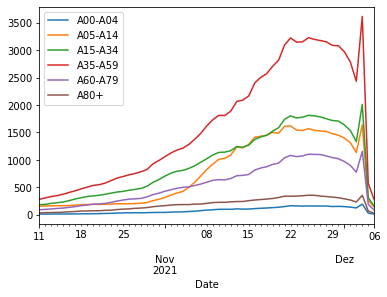

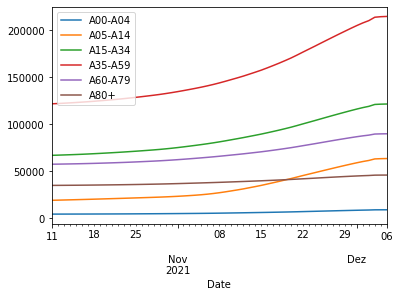

In [78]:
rki_df = rki_df_backup.copy()
rki_df = rki_df[
    (rki_df.ID_County >= 14000) & (rki_df.ID_County < 15000) & 
    (rki_df.Age_RKI != "unknown")]# &
    #(rki_df.Date.dt.date >= start_date.date() - datetime.timedelta(days = 1))]
rki_df = rki_df.sort_values(by = 'Date')
rki_df['ConfirmedNew'] = rki_df.groupby(['ID_County', 'Age_RKI']).Confirmed.diff() #de-aggregate
rki_df = rki_df[rki_df.Date.dt.date >= start_date.date()]
rki_df = rki_df[['Date', 'Age_RKI', 'Confirmed', 'ConfirmedNew']].groupby(['Date','Age_RKI'], as_index = False).sum() #sum over counties
d = dict()
for key in [*['Group' + str(i + 1) for i in range(6)], 'Total']:
    d[key] = np.zeros((daysPlotRKI, 10))
    key_map = {'Group1' : 'A00-A04', 'Group2' : 'A05-A14', 'Group3': 'A15-A34', 'Group4' : 'A35-A59', 'Group5' : 'A60-A79', 'Group6' : 'A80+'}
    for t in range(daysPlotRKI):
        rki_df_t = rki_df[(rki_df.Date.dt.date == start_date.date() + datetime.timedelta(days = t))]
        if (key == 'Total'):
            d[key][t, 4] = rki_df_t.ConfirmedNew.sum()
        else:
            d[key][t, 4] = rki_df_t[(rki_df.Age_RKI == key_map[key])].ConfirmedNew.sum()

#plot
rki_df = rki_df.set_index('Date')
plt.figure()
rki_df.groupby(['Age_RKI']).ConfirmedNew.plot(legend=True)
plt.figure()
rki_df.groupby(['Age_RKI']).Confirmed.plot(legend=True)

12_07_delayedpeak
12_07_delayed_flat
12_07_delayed_rising


C:\Users\abel_da\AppData\Local\Temp/ipykernel_6628/1126628378.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


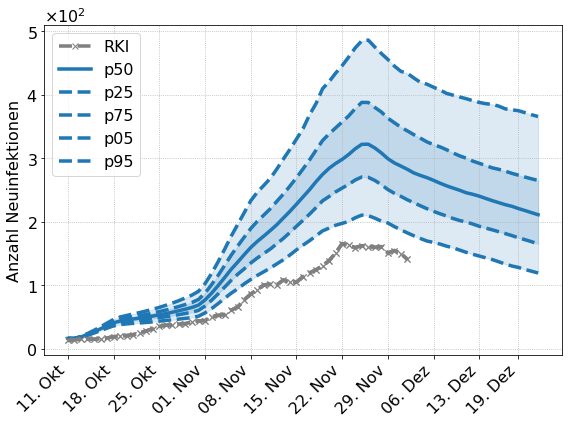

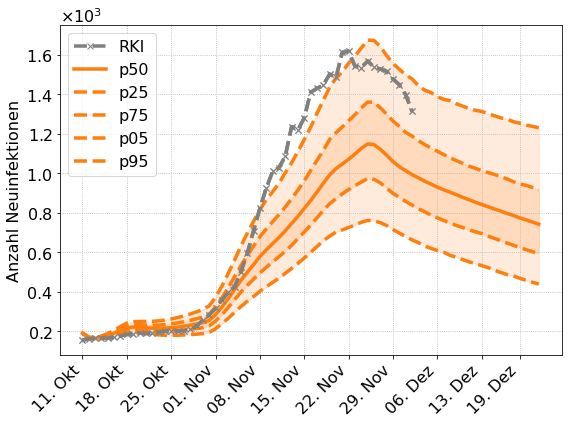

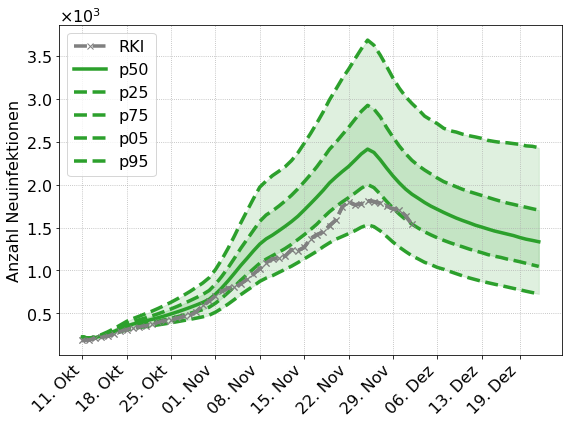

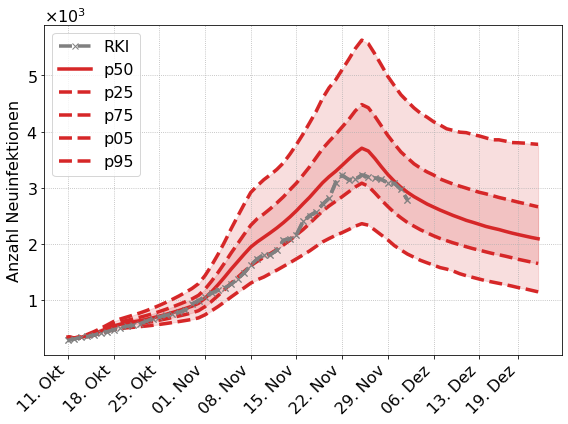

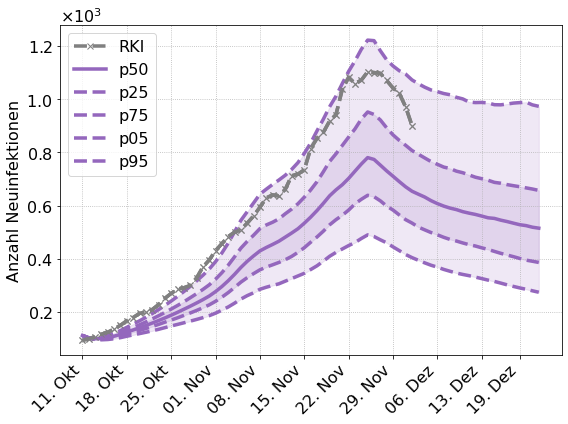

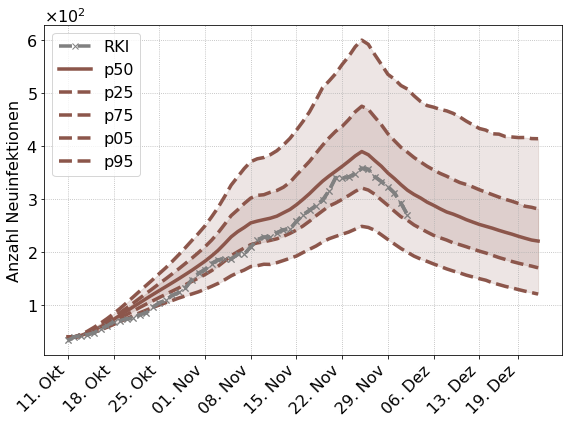

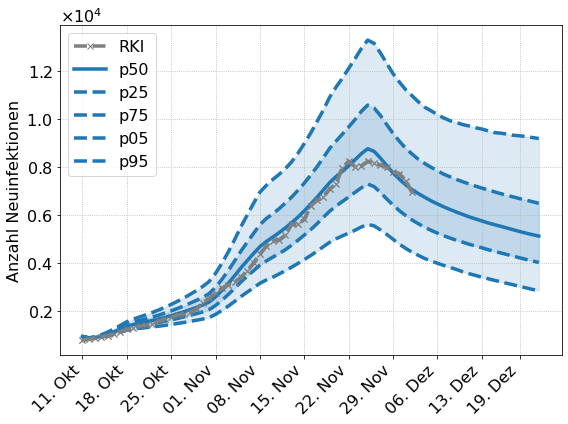

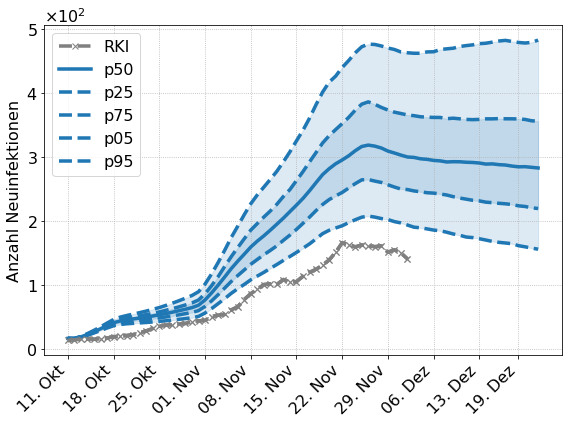

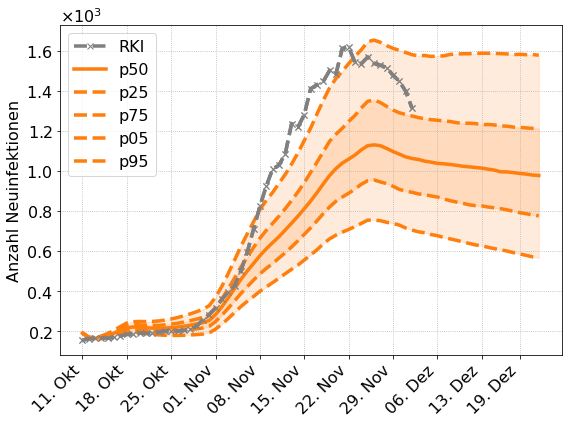

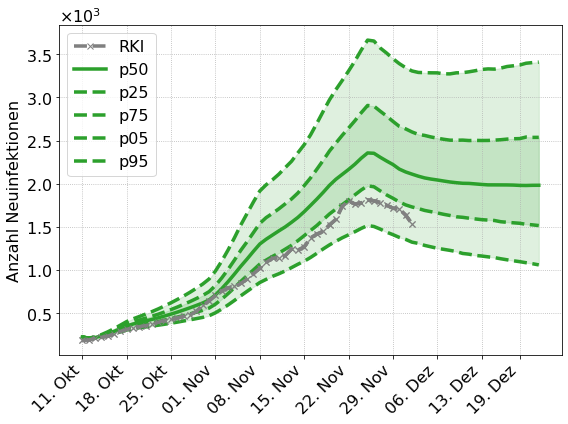

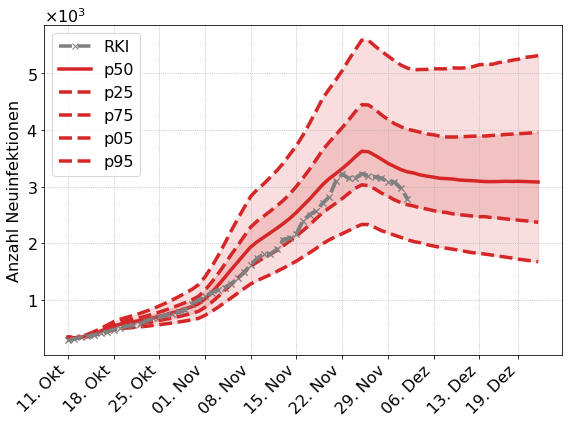

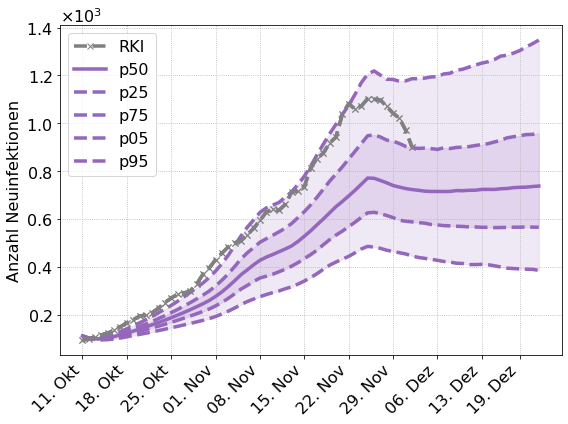

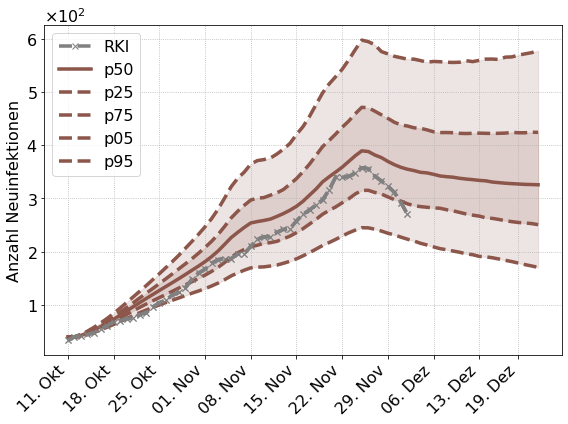

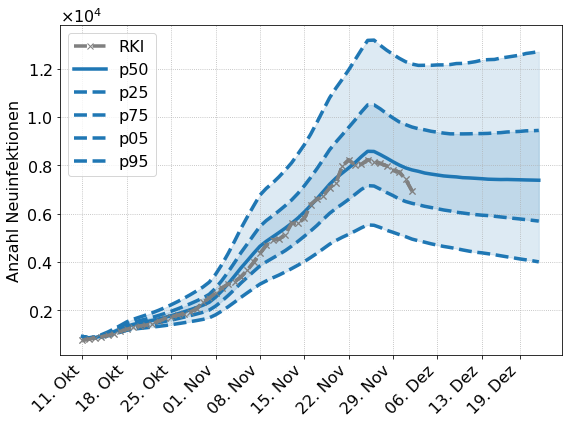

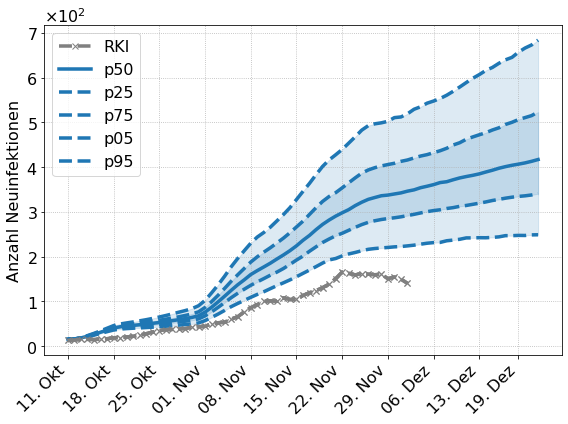

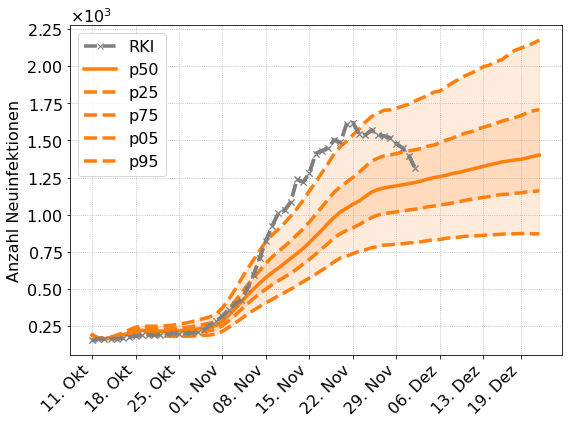

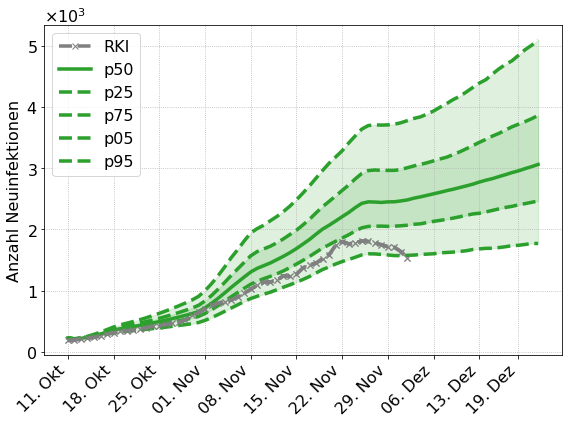

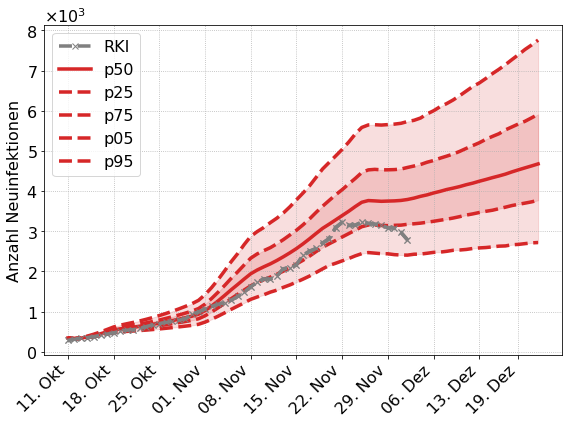

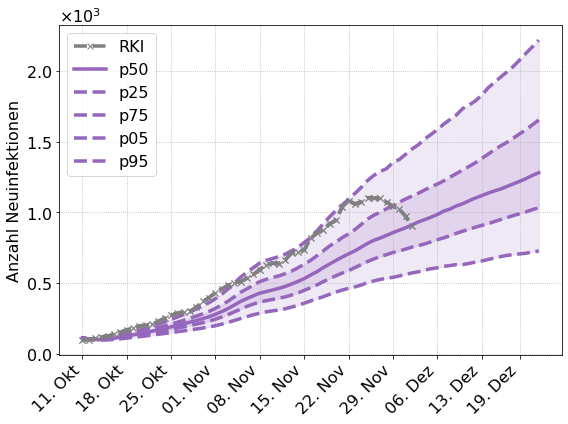

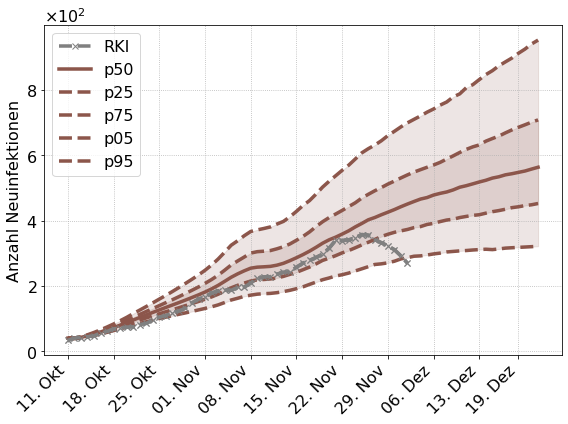

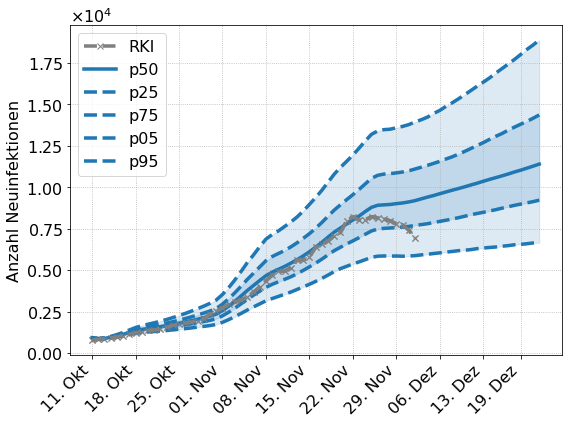

In [84]:
ylim = {}
# comparts = [4, 6, 8]
comparts = [4]
for compart in comparts:
    strings = ['12_07_delayedpeak', '12_07_delayed_flat', '12_07_delayed_rising']
               
    files = open_files()
    new_files = concat_comparts(files, concat_comps)
    
    # plot_all_results(new_files, compart, new_secir_dict[compart], filename=high + '_all', key='Group2')

    for scenario in strings:
        for key in [*['Group' + str(i + 1) for i in range(6)], 'Total']:
            ylim = plot_results(new_files[scenario], compart, new_secir_dict[compart], None, filename="_" + scenario + '_' + key, key=key)
            dummy = 1
    close_files(files)
            


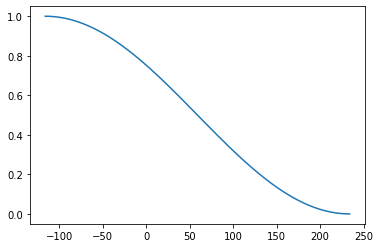

In [19]:
x = np.linspace(-116, -116 + 350, 100)
f = lambda x: (np.cos((x + 116) / 350 * np.pi) + 1) / 2
plt.plot(x, f(x))